In [14]:
import math
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score
from callback import MultipleClassAUROC
from utility import get_sample_counts
from weights import get_class_weights
from generator import AugmentedImageSequence
from augmenter import augmenter

In [2]:
epochs = 10
batch_size = 32
initial_learning_rate = 0.001
patience_reduce_lr = 1 # Reduce the learning rate by the factor of 10 of validation loss doesn't decrease for x epochs
min_lr=1e-8
base_model_name = "DenseNet121"
image_dimension = 224
use_base_model_weights = True
positive_weights_multiply = 1
generator_workers = 8

class_names = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

image_source_dir = "data/images"
model_weights_file = 'weights/best.h5'
output_weights_path = 'weights/weights.h5'
split_dir = 'data/split'
output_dir = 'output'

trainable_layer = 10 #Number of layers to be trained starting from the end
train_steps = 'auto' #if auto then total_no_of_samples/batch_size
validation_steps = 'auto'
test_steps = 'auto'

show_model_summary = True

use_trained_model_weights = True  #continue training

In [3]:
if use_trained_model_weights:
    # resuming mode
    print("** use trained model weights **")
    # load training status for resuming
    training_stats_file = os.path.join(output_dir, ".training_stats.json")
    if os.path.isfile(training_stats_file):
        training_stats = json.load(open(training_stats_file))
    else:
        training_stats = {}
else:
    # start over
    training_stats = {}

# get train/dev sample counts
train_counts, train_pos_counts = get_sample_counts(split_dir, "train", class_names)
dev_counts, dev_pos_counts = get_sample_counts(split_dir, "dev", class_names)
# get test sample count
test_counts, test_pos_counts = get_sample_counts(split_dir, "test", class_names)

# compute steps
if train_steps == "auto":
    train_steps = int(train_counts / batch_size)
else:
    try:
        train_steps = int(train_steps)
    except ValueError:
        raise ValueError(f"""
        train_steps: {train_steps} is invalid,
        please use 'auto' or integer.
        """)
print(f"** train_steps: {train_steps} **")

if validation_steps == "auto":
    validation_steps = int(dev_counts / batch_size)
else:
    try:
        validation_steps = int(validation_steps)
    except ValueError:
        raise ValueError(f"""
        validation_steps: {validation_steps} is invalid,
        please use 'auto' or integer.
        """)
print(f"** validation_steps: {validation_steps} **")

# compute steps
if test_steps == "auto":
    test_steps = int(test_counts / batch_size)
else:
    try:
        test_steps = int(test_steps)
    except ValueError:
        raise ValueError(f"""
            test_steps: {test_steps} is invalid,
            please use 'auto' or integer.
            """)
print(f"** test_steps: {test_steps} **")
    
# compute class weights
print("** compute class weights from training data **")
class_weights = get_class_weights(
    train_counts,
    train_pos_counts,
    multiply=positive_weights_multiply,
)
print("** class_weights **")
print(class_weights)

** use trained model weights **
** train_steps: 10 **
** validation_steps: 10 **
** test_steps: 47 **
** compute class weights from training data **
** class_weights **
[{0: 0.1032743176107264, 1: 0.8967256823892736}, {0: 0.024590950070013235, 1: 0.9754090499299868}, {0: 0.11874436537318013, 1: 0.8812556346268199}, {0: 0.17674026048759903, 1: 0.823259739512401}, {0: 0.05132066061803464, 1: 0.9486793393819654}, {0: 0.05654767613603667, 1: 0.9434523238639633}, {0: 0.012736654326434312, 1: 0.9872633456735657}, {0: 0.04782958970325897, 1: 0.952170410296741}, {0: 0.04120230947768208, 1: 0.9587976905223179}, {0: 0.020505246197226323, 1: 0.9794947538027736}, {0: 0.022826232904302458, 1: 0.9771737670956976}, {0: 0.015076822741833388, 1: 0.9849231772581666}, {0: 0.030201599754474135, 1: 0.9697984002455259}, {0: 0.002004488519747569, 1: 0.9979955114802525}]


Total number of datapoints: 112120
Number of trainig datapoints: 104266 0.929950053514092
Number of validation datapoints: 6336 0.05651088119871566
Number of test datapoints: 1518 0.013539065287192294
Distribution in dataset [train/valid/test]


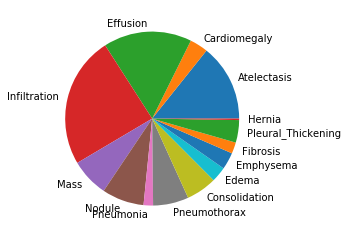

In [8]:
total_counts = train_counts+dev_counts+test_counts
print("Total number of datapoints:", total_counts)
print("Number of trainig datapoints:", train_counts, train_counts/total_counts)
print("Number of validation datapoints:", dev_counts, dev_counts/total_counts)
print("Number of test datapoints:", test_counts, test_counts/total_counts)

print("Distribution in dataset [train/valid/test]")
from matplotlib import pyplot as plt
%matplotlib inline
plt.pie([v for v in train_pos_counts.values()], labels=[k for k in train_pos_counts.keys()],autopct=None)
plt.show()

In [13]:
print("** create image generators **")
train_generator = AugmentedImageSequence(
    dataset_csv_file="data/split/train.csv",
    class_names=class_names,
    source_image_dir= image_source_dir,
    batch_size=batch_size,
    target_size=(image_dimension, image_dimension),
    augmenter=augmenter,
)
validation_generator = AugmentedImageSequence(
    dataset_csv_file="data/split/dev.csv",
    class_names=class_names,
    source_image_dir= image_source_dir,
    batch_size=batch_size,
    target_size=(image_dimension, image_dimension),
    augmenter=augmenter,
    shuffle_on_epoch_end=False,
)
test_generator = AugmentedImageSequence(
    dataset_csv_file="data/split/test.csv",
    class_names=class_names,
    source_image_dir=image_source_dir,
    batch_size=batch_size,
    target_size=(image_dimension, image_dimension),
    augmenter=None,
    shuffle_on_epoch_end=False,
)

** create image generators **


In [10]:
model = DenseNet121(include_top=True, weights=None, input_shape=(image_dimension,image_dimension,3), classes=14)
model.load_weights(model_weights_file)

if trainable_layer is not 'all':
    for layer in model.layers[:-trainable_layer]:
        layer.trainable=False
    for layer in model.layers[-trainable_layer:]:
        layer.trainable=True

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

if show_model_summary:
    print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________________

# Training

In [11]:
print("** compile model with class weights **")
optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss="binary_crossentropy")

auroc = MultipleClassAUROC(
    sequence=test_generator,
    class_names=class_names,
    weights_path=output_weights_path,
    stats=training_stats,
    workers=generator_workers,
)

checkpoint = ModelCheckpoint(
     output_weights_path,
     save_weights_only=True,
     save_best_only=True,
     verbose=1,
)

callbacks = [
    checkpoint,
    TensorBoard(log_dir=os.path.join(output_dir, "logs"), batch_size=batch_size),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
                      verbose=1, mode="min", min_lr=min_lr),
    auroc,
]

print("** start training **")
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights,
    workers=generator_workers,
    shuffle=False,
)

# dump history
print("** dump history **")
with open(os.path.join(output_dir, "history.pkl"), "wb") as f:
    pickle.dump({
        "history": history.history,
        "auroc": auroc.aurocs,
    }, f)
print("** done! **")

** compile model with class weights **
** start training **
Instructions for updating:
Use tf.cast instead.
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10/10 [==============================] - 70s 7s/step - loss: 0.3656 - val_loss: 0.3847

Epoch 00001: val_loss improved from inf to 0.38472, saving model to weights/weights.h5

*********************************
current learning rate: 9.999999747378752e-05
*** epoch#1 dev auroc ***
1. Atelectasis: 0.7863313984362521
2. Cardiomegaly: 0.8655807860717809
3. Effusion: 0.8447954095311165
4. Infiltration: 0.5196716643732214
5. Mass: 0.8312177238328247
6. Nodule: 0.6597284751762039
7. Pneumonia: 0.6883085880522675
8. Pneumothorax: 0.8623172453487343
9. Consolidation: 0.72417014805608
10. Edema: 0.8594710626185958
11. Emphysema: 0.8656514051284918
12. Fibrosis: 0.7623123147979539
13. Pleural_Thickening: 0.7266124130717477
14. Hernia: 0.8572061382692612
*********************************
mean auroc: 0.7752410551974667
update best auroc from 0 to 0.7752410551974667
update log file: weights/best_auroc.log
update model file: weights/weights.h5 -> weights/best_weights.h5
******************************

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 68s 7s/step - loss: 0.4075 - val_loss: 0.3749

Epoch 00002: val_loss improved from 0.38472 to 0.37489, saving model to weights/weights.h5

*********************************
current learning rate: 9.999999747378752e-05
*** epoch#2 dev auroc ***
1. Atelectasis: 0.7826975300380359
2. Cardiomegaly: 0.8640182452990693
3. Effusion: 0.8432374166447149
4. Infiltration: 0.5255219536145141
5. Mass: 0.8249204251716256
6. Nodule: 0.6589449692613407
7. Pneumonia: 0.6925306947358199
8. Pneumothorax: 0.8639394081012209
9. Consolidation: 0.720640033219329
10. Edema: 0.8574644212523719
11. Emphysema: 0.8705171124452241
12. Fibrosis: 0.7662430586595004
13. Pleural_Thickening: 0.7243543987109176
14. Hernia: 0.8592838685861943
*********************************
mean auroc: 0.7753081096957056
update best auroc from 0.7752410551974667 to 0.7753081096957056


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


update log file: weights/best_auroc.log
update model file: weights/weights.h5 -> weights/best_weights.h5
*********************************
Epoch 3/10
10/10 [==============================] - 66s 7s/step - loss: 0.3335 - val_loss: 0.3424

Epoch 00003: val_loss improved from 0.37489 to 0.34243, saving model to weights/weights.h5

*********************************
current learning rate: 9.999999747378752e-05


KeyboardInterrupt: 

# Testing

In [24]:
print("** make prediction **")
y_hat = model.predict_generator(test_generator, verbose=1)
y = test_generator.get_y_true()

** make prediction **
48/48 [==============================] - 171s 4s/step


In [25]:
aurocs = []
for i in range(len(class_names)):
    score = roc_auc_score(y[:, i], y_hat[:, i])
    aurocs.append(score)
print("Mean AUC: ",np.mean(aurocs))

Mean AUC:  0.74370926081423


In [6]:
print("** make prediction **")
y_hat_valid = model.predict_generator(validation_generator, verbose=1)
y_valid = validation_generator.get_y_true()

** make prediction **


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


198/198 [==============================] - 746s 4s/step


In [22]:
aurocs = []
for i in range(len(class_names)):
    score = roc_auc_score(y_valid[:, i], y_hat_valid[:, i])
    aurocs.append(score)
print("Mean AUC: ",np.mean(aurocs))
y_true = (y_valid > 0.5)
y_pred = (y_hat_valid > 0.5)
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)
print("Accuracy score: ", accuracy_score(y_true, y_pred))

Mean AUC:  0.775508795690526
Accuracy score:  0.12705176767676768


In [30]:
scores = model.evaluate_generator(validation_generator, steps=math.ceil(6336//batch_size), max_queue_size=10, workers=10, use_multiprocessing=False)
print("Testing data score = Loss: %f, Acc: %.2f" % (scores[0],scores[1]))

Testing data score = Loss: 3.511608, Acc: 0.13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

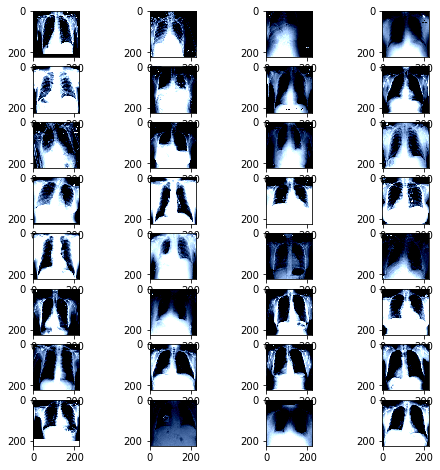

In [149]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 8
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(train_generator.__getitem__(0)[0][i])
plt.show()